In [1]:
import tensorflow as tf
import numpy as np
import imageio
import os
from tensorflow.keras.applications import EfficientNetB0  # Resolution 224x224
from sklearn.model_selection import train_test_split
from matplotlib.image import imread
import matplotlib.pyplot as plt
import random


IMG_SIZE = 224
batch_size = 1
NUM_CLASSES = 3

In [4]:
from IPython.display import clear_output


def load_lightfield_data(lf_directory):
    """
    Loads the center image (003) from each light field.
    
    :param lf_directory: Path to directory
    :return: features: (#LF, resX, resY, RGB)
             labels: (#LF)
    """
    good = 0
    scratch = 0
    dent = 0
    error = 0
    image_dirs = []
    for path, subdirs, files in os.walk(lf_directory):
        for name in files:
            if '0002_Set0_Cam_003_img.png' in name:
                image_dirs.append(os.path.join(path, name))
    random.seed(1)
    random.shuffle(image_dirs)
    print(len(image_dirs))
    features = np.zeros((len(image_dirs), IMG_SIZE, IMG_SIZE, 3), np.float32)
    labels = np.zeros((len(image_dirs)), np.int64)
    for i, lf in enumerate(image_dirs):
        clear_output()
        print(lf, flush=True)
        tmp = imageio.imread(lf).astype('float32')
        tmp = tf.image.resize(tmp, (IMG_SIZE, IMG_SIZE))
        features[i, :, :, :] = tmp[:, :, :3]  # center image ,[:,:,3] is alpha channel
        del tmp

        # 0: no defect, 1: scratch, 2: dent
        if 'good' in lf:
            gt = 0
            good += 1
        elif 'scratch' in lf:
            gt = 1
            scratch += 1
        elif 'dent' in lf:
            gt = 2
            dent += 1
        labels[i] = gt
        
    print(f"Good: {good/(good+scratch+dent+error)}")
    print(f"Scratch: {scratch / (good + scratch + dent + error)}")
    print(f"Dent: {dent / (good + scratch + dent + error)}")
    print(f"Error: {error / (good + scratch + dent + error)}")
    
    return features, labels  # Data does not need to be normalized, it's part of the model

In [6]:
# (x_all, y_all) = load_lightfield_data("C:\\Users\\muell\\Desktop\\blender_output_tmp")
(x_all, y_all) = load_lightfield_data("C:\\Users\\muell\\Google Drive\\University\\Master_Project\\data_storage\\lightfields")

C:\Users\muell\Google Drive\University\Master_Project\data_storage\lightfields\dent\0290_m1_sc14.93_b1.67_s0.99_r0.86_m0.1_r1.07_t1.67_p1.48\0002_Set0_Cam_003_img.png
Good: 0.6156620298815044
Scratch: 0.18804739824832561
Dent: 0.19629057187017002
Error: 0.0


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.3, random_state=1)

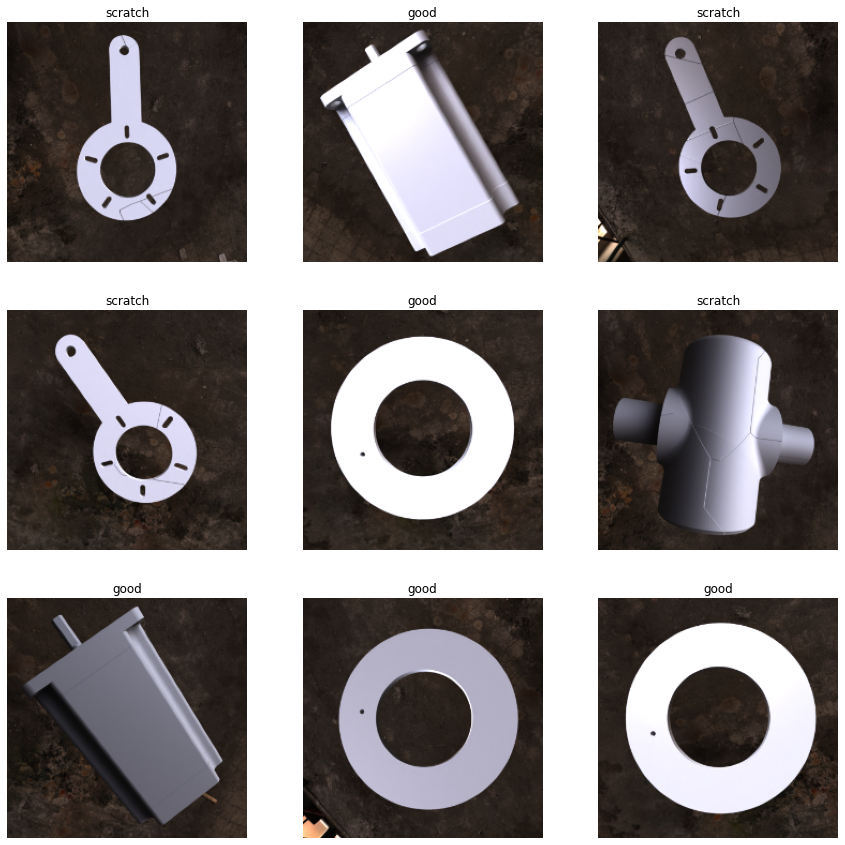

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i in range(9):
    k = np.random.randint(0,500)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_all[k].astype("uint8"))
    plt.title({0:'good', 1:'scratch', 2:' dent'}[y_all[k]])
    plt.axis("off")

In [11]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.5),
        preprocessing.RandomTranslation(height_factor=0.03, width_factor=0.03),
        preprocessing.RandomFlip(),
#         preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

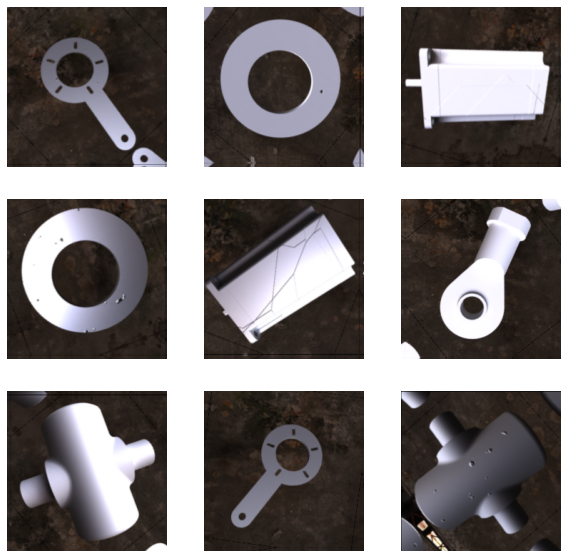

In [12]:
plt.figure(figsize=(10,10))
for i in range(9):
    j = np.random.randint(0,500)
    ax = plt.subplot(3, 3, i + 1)
    aug_img = img_augmentation(tf.expand_dims(x_train[j], axis=0))
    plt.imshow(aug_img[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
y_train_cat = tf.one_hot(y_train, NUM_CLASSES)
y_test_cat = tf.one_hot(y_test, NUM_CLASSES)
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)

In [ ]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 100
hist = model.fit(x=x_train, y=y_train_cat, epochs=epochs, batch_size=16,
                 validation_data=(x_test, y_test_cat), verbose=2)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 3)                 4053414   
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/100
85/85 - 17s - loss: 2.9470 - accuracy: 0.4551 - val_loss: 1.3725 - val_accuracy: 0.6106
Epoch 2/100
85/85 - 14s - loss: 1.7912 - accuracy: 0.5272 - val_loss: 1.3426 - val_accuracy: 0.6106
Epoch 3/100
85/85 - 13s - loss: 1.4328 - accuracy: 0.5692 - val_loss: 1.0358 - val_accuracy: 0.6106
Epoch 4/100
85/85 - 14s - loss: 1.2347 - accuracy: 0.5935 - val_loss: